# REIT Assessment

The goal is to find very high dividend REITs that we will split our money between them. In order to do that I asked GPT to provide me with the list of highest dividend reits then I find their covariance matrices and use that as a metric for clustering. Particularly we use inverse covariance as a distance metric. Then we use a clustering algorithm to cluster the REITs based on their similatiry. The least related REITs are clustered together. Ideally one should perform a fundamentals analysis and pick the REITs that are the least correlated while also have very good fundamentals (indeally one per cluster.)

In [1]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import pandas as pd
import numpy as np
import time
import os

In [3]:
API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
API_KEY

'0NMM29NQL333391O'

In [ ]:
API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
ts = TimeSeries(key=API_KEY, output_format='pandas')
fd = FundamentalData(key=API_KEY, output_format='pandas')

tickers = [
    "CHKR", "OXSQ", "VOC", "USEA", "FAT", "MIND", "NHTC", "ABEV", "LYG", "MFG",
    "NOK", "BTG", "SAN", "PBI", "CCEL", "WHF", "OFS", "MRCC", "PTMN", "TPVG",
    "CMBT", "ZIM", "OXLC", "ECC", "ORC", "PSEC", "TWO", "AGNC", "FSK", "DX",
    "NLY", "INSW", "MITT", "SUNS", "PBR", "EFC", "SDIV", "QYLD", "TRIN", "ENG.MC",
    "ARLP", "BCSF", "RA", "USA", "GBDC", "NMFC", "PNNT", "GSBD"] #['AGNC', 'NLY', 'OHI', 'ARR', 'LTC', 'IIPR', 'ORC', 'CHCT', 'ABR', 'PMT']

price_data = {}
fundamental_data = {}

for symbol in tickers:
    try:
        # Fetch daily adjusted close price
        df, _ = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
        df = df[['5. adjusted close']].rename(columns={'5. adjusted close': symbol})
        price_data[symbol] = df

        # Fetch fundamentals
        overview, _ = fd.get_company_overview(symbol)
        fundamental_data[symbol] = overview.T

        time.sleep(12)  # Respect API limits (5 requests/minute)
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")

# Combine price data to aligned date index
prices = pd.concat(price_data.values(), axis=1, join='inner')
prices.index = pd.to_datetime(prices.index)
prices.sort_index(inplace=True)

# Compute log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Compute normalized covariance matrix
cov_matrix = returns.cov()

# Save outputs
prices.to_csv('reit_prices.csv')
returns.to_csv('reit_returns.csv')
cov_matrix.to_csv('reit_covariance_matrix.csv')

# Combine and save fundamental data
fundamentals_df = pd.concat(fundamental_data.values(), axis=1)
fundamentals_df.columns = tickers
fundamentals_df.to_csv('reit_fundamentals.csv')

In [7]:
fundamentals_df.columns = fundamentals_df.iloc[0].tolist()
fundamentals_df.to_csv('reit_fundamentals.csv')

In [8]:
tickers = fundamentals_df.columns

In [9]:
spearman_corr = returns.corr(method='spearman')
kendall_corr = returns.corr(method='kendall')
linear_corr = returns.corr()

In [10]:
linear_corr

,CHKR,OXSQ,VOC,USEA,FAT,MIND,NHTC,ABEV,LYG,MFG,...,QYLD,TRIN,ARLP,BCSF,RA,USA,GBDC,NMFC,PNNT,GSBD
CHKR,1.000000,-0.023717,0.086572,0.042115,-0.086226,0.018482,-0.109084,-0.148504,-0.094569,0.006325,...,-0.052140,-0.078128,-0.007436,-0.036247,-0.060520,-0.034768,-0.001123,0.017700,-0.093716,-0.065087
OXSQ,-0.023717,1.000000,0.190554,0.027165,0.326642,0.132128,0.160881,0.209678,0.293743,0.312854,...,0.391259,0.411003,0.138555,0.419771,0.445691,0.449729,0.464532,0.423351,0.475342,0.457764
VOC,0.086572,0.190554,1.000000,0.165446,0.156261,0.106870,-0.055137,0.131801,0.110055,0.230492,...,0.322472,0.276013,0.270574,0.353021,0.262918,0.262934,0.401836,0.422315,0.304753,0.372752
USEA,0.042115,0.027165,0.165446,1.000000,0.068967,0.054098,-0.085307,0.039813,0.053597,0.090263,...,0.074900,0.110124,0.090035,0.137611,0.043637,0.091846,0.127662,0.070853,0.088066,0.110662
FAT,-0.086226,0.326642,0.156261,0.068967,1.000000,0.137801,0.122004,0.144778,0.121241,0.220902,...,0.291323,0.279835,0.018331,0.282138,0.209818,0.331475,0.325467,0.317866,0.297835,0.284735
MIND,0.018482,0.132128,0.106870,0.054098,0.137801,1.000000,-0.041171,0.082343,0.146782,0.129641,...,0.212270,0.125110,0.113237,0.146524,0.140343,0.163908,0.254052,0.212449,0.169365,0.193502
NHTC,-0.109084,0.160881,-0.055137,-0.085307,0.122004,-0.041171,1.000000,0.085873,0.115275,0.105931,...,0.060487,0.061337,-0.136692,0.098850,0.108807,0.099854,0.080245,0.088882,0.053903,-0.006252
ABEV,-0.148504,0.209678,0.131801,0.039813,0.144778,0.082343,0.085873,1.000000,0.328915,0.258662,...,0.222156,0.213844,0.088902,0.238525,0.184857,0.279888,0.296998,0.245517,0.317462,0.259619
LYG,-0.094569,0.293743,0.110055,0.053597,0.121241,0.146782,0.115275,0.328915,1.000000,0.461205,...,0.543945,0.330712,0.306742,0.403448,0.369630,0.486614,0.459397,0.339461,0.418262,0.411351
MFG,0.006325,0.312854,0.230492,0.090263,0.220902,0.129641,0.105931,0.258662,0.461205,1.000000,...,0.582232,0.340872,0.345628,0.444333,0.429871,0.485860,0.522386,0.403535,0.440779,0.419482


In [11]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np

# X: rows = time steps (samples), columns = assets
X = returns[tickers].to_numpy()

# Standardize data (optional but common)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Fit Graphical Lasso with cross-validated alpha
model = GraphicalLassoCV(alphas=np.logspace(-2, 2, 20))
model.fit(X)

# The estimated sparse inverse covariance matrix (precision)
precision_matrix = model.precision_
# The estimated covariance matrix
covariance_matrix = model.covariance_


/home/ubuntu/env-310/lib/python3.10/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [12]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
symbols = np.array(tickers)

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(symbols[labels == i])}")

Cluster 1: USEA
Cluster 2: MIND
Cluster 3: NHTC
Cluster 4: BTG
Cluster 5: LYG, NOK, SAN
Cluster 6: CCEL
Cluster 7: VOC, ABEV, MFG, PBI, WHF, OFS, MRCC, PTMN, TPVG, PSEC, FSK, PBR, TRIN, ARLP, BCSF, GBDC, NMFC, PNNT, GSBD
Cluster 8: OXSQ, FAT, ORC, TWO, AGNC, DX, NLY, MITT, SUNS, EFC
Cluster 9: CMBT, ZIM, INSW


In [13]:
from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=2
)

embedding = node_position_model.fit_transform(X.T).T

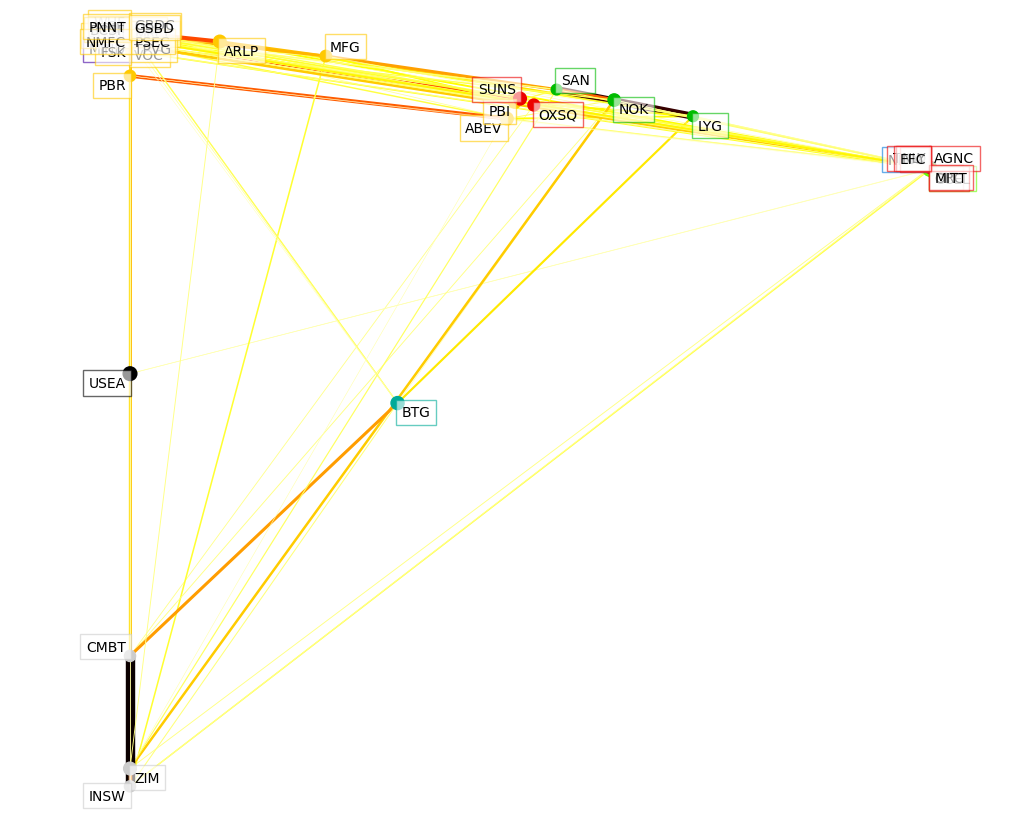

In [14]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()

##### 